# TGEditor for Financial Fraud Detection
The workflow of the pipeline consists of two stage: the graph editing (augmentation) and detection. The graph editing is proposed in the paper TGEditor to conduct task-guided temporal graph augmentation to boost the fraud detection performance. The detection stage is using a logistic regression classifier to perform the fraud detection.
1. The graph editing part includes two steps, the contextualization and editing steps. HTNE model is used to calculate node embedding for each node that include the aggreagted neighborhood information through a random walk process. The editing step directly perform editing on this graph with node embedding to update its structure.
2. The detection part also includes two steps, the contextualization update and classification steps. Since the graph structure was edited, we need to run the HTNE model once again to update the node embedding. Then a logistic regression is performed on node level using the assigned node embedding to detect fradulent transaction.
![image](../docs/flow.png)

**Tell me what's your task today?**

In [1]:
# You can select from ['Chase', 'Small', 'Medium']
# Recommend to use Chase dataset for learning the code
task = 'Chase'

# Loading necessary arguments and preliminary files

In [2]:
import yaml
import argparse
import torch
from utils import *
from HTNE import *



def load_config(filename):
    with open(filename, 'r') as f:
        config = yaml.safe_load(f)
    return config

config = load_config(f"config-{task}.yml")

# Access the variables
device = auto_select_device(config['device'], strategy='greedy')
data_path = config['data_path']

# For Train_HTNE
HTNE_args = argparse.Namespace(**config['HTNE'])

# For Dynamic_Graph_Experiments
TGEditor_args = argparse.Namespace(**config['TGEditor'])
from TGEditor import *

# AML Data Preprocessing Script

This script preprocesses the input data into a specific format. Below are the fields the script generates. The preprocessing takes a while to run, and will save the preprocessed results.

## Output Fields

- `src`: Source node
- `tar`: Target node
- `timestamp`: Timestamp of the event
- `label`: Indicates if the data is fraudulent or not

The preprocessing is time-consuming to run. But it only needs to run once. The results are stored in the disk, and you can directly load the preprocessed results without running the preprocessing every time:

In [19]:
import pandas as pd

start_time = time.time()
df = pd.read_csv(data_path, sep=',')
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.date
unique_dates = sorted(df['Timestamp'].unique())
date_mapping = {date: i for i, date in enumerate(unique_dates)}
df['Timestamp'] = df['Timestamp'].map(date_mapping)
account_mapping = {value: idx for idx, value in enumerate(pd.concat([df['Account'], df['Account.1']]).unique())}
df['Account'] = df['Account'].map(account_mapping)
df['Account.1'] = df['Account.1'].map(account_mapping)

# Select only the desired columns
df[['Timestamp', 'Account', 'Account.1', 'Is Laundering']]
cleaned_df = df[['Account', 'Account.1', 'Timestamp', 'Is Laundering']]

# Rename columns
cleaned_df.columns = ['src', 'tar', 't', 'label']
cleaned_df.to_csv('../small_AML/small.csv', index=False)
cleaned_df
end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")

Elapsed time: 144.77789664268494 seconds


In [20]:
cleaned_df

,src,tar,t,label
0,0,0,0,0
1,1,1,0,0
2,2,2,0,0
3,3,3,0,0
4,4,4,0,0
...,...,...,...,...
31251478,955664,957418,15,0
31251479,955664,957418,15,0
31251480,955664,957418,15,0
31251481,955664,957418,15,0


Let's just load the preprocessed results on disk:

In [3]:
# Choose one of the preprocssed results based on your task
cleaned_df = pd.read_csv('../Chase/edges_lab.csv', sep=',')

In [3]:
cleaned_df = pd.read_csv('../small_AML/small.csv', sep=',')

In [ ]:
cleaned_df = pd.read_csv('../medium_AML/medium.csv', sep=',')

# Preprocess the Data into Node Embeddings
(Skip if fast mode not enabled)

In [4]:
start_time = time.time()
data = HTNE_dataset(edge_list=cleaned_df, neg_size=HTNE_args.neg_size, hist_len=HTNE_args.hist_len)
end_time = time.time()
print("Elapsed time:", end_time - start_time, "seconds")
dataloader_lp = load_data(data, batch_size=HTNE_args.batch_size)

loading edge list to CTNDE
Building index now
Finidng neighbors now
built successfully
Now building HTNE related data: Find hist
Elapsed time: 0.47751784324645996 seconds for finidng node history
46
Now building HTNE related data: Iterate data
Elapsed time: 0.4800388813018799 seconds is used for computing degree
Now building HTNE related data: Build hist
Now building HTNE related data: Node hist
done initializing
Elapsed time: 34.036123275756836 seconds


In [5]:
random.seed(HTNE_args.seed)
np.random.seed(HTNE_args.seed)
torch.manual_seed(HTNE_args.seed)
torch.cuda.manual_seed_all(HTNE_args.seed)

exp_ID = int(SystemRandom().random() * 100000)
start_time = time.time()

dataloader_lp = load_data(data, batch_size=HTNE_args.batch_size)

model_htne_pre = Htne(emb_size=HTNE_args.emb_size, node_dim=data.num_nodes).to(device)
optimizer_htne = SparseAdam(model_htne_pre.parameters(), lr=HTNE_args.lr, eps=1e-8)
model_htne_pre.zero_grad()
optimizer_htne.zero_grad()
end_time = time.time()
print(f"Total processing time is: {end_time-start_time}")
# torch.cuda.empty_cache()

for i in range(HTNE_args.epochs):
    total_loss = 0
    total_samples = 0 
    model_htne_pre.train()
    print(f"Now at {i + 1} out of {HTNE_args.epochs}.")
    for j, batch in enumerate(dataloader_lp):
        src = batch['source'].to(device)
        tar = batch['target'].to(device)
        dat = batch['date'].to(device)
        hist_nodes = batch['hist_nodes'].to(device)
        hist_times = batch['hist_times'].to(device)
        hist_masks = batch['hist_masks'].to(device)
        negs = batch['negs'].to(device)
        loss = model_htne_pre(src, tar, dat, hist_nodes,
            hist_times, hist_masks, negs)
        loss = loss.sum()
        total_loss += loss.item()
        total_samples += src.size(0)
        avg_loss = total_loss / total_samples
        if (j + 1) % 5 == 0:
            print(f"{i + 1} epochs {j + 1} batch: {avg_loss:.04f}")
        loss.backward()
        optimizer_htne.step()
        optimizer_htne.zero_grad()
model_htne_pre.eval()

Total processing time is: 1.1221647262573242
Now at 1 out of 25.
1 epochs 5 batch: 7.3292
1 epochs 10 batch: 6.8523
1 epochs 15 batch: 6.3877
1 epochs 20 batch: 6.0227
1 epochs 25 batch: 5.7840
Now at 2 out of 25.
2 epochs 5 batch: 4.2851
2 epochs 10 batch: 4.1973
2 epochs 15 batch: 4.1256
2 epochs 20 batch: 4.0561
2 epochs 25 batch: 4.0117
Now at 3 out of 25.
3 epochs 5 batch: 3.1035
3 epochs 10 batch: 3.0322
3 epochs 15 batch: 2.9860
3 epochs 20 batch: 2.9618
3 epochs 25 batch: 2.9246
Now at 4 out of 25.
4 epochs 5 batch: 2.3823
4 epochs 10 batch: 2.3754
4 epochs 15 batch: 2.3588
4 epochs 20 batch: 2.3247
4 epochs 25 batch: 2.3174
Now at 5 out of 25.
5 epochs 5 batch: 1.9450
5 epochs 10 batch: 1.9120
5 epochs 15 batch: 1.8948
5 epochs 20 batch: 1.8835
5 epochs 25 batch: 1.8760
Now at 6 out of 25.
6 epochs 5 batch: 1.6289
6 epochs 10 batch: 1.6021
6 epochs 15 batch: 1.6024
6 epochs 20 batch: 1.5867
6 epochs 25 batch: 1.5777
Now at 7 out of 25.
7 epochs 5 batch: 1.3545
7 epochs 10 batc

Htne(
  (node_emb): Embedding(3390, 128, sparse=True)
  (delta): Embedding(3390, 1, sparse=True)
)

It also takes a while to generate the node embedding. We can store the node embedding so don't need to generate it one more time in the future.

In [6]:
torch.save(model_htne_pre.state_dict(), f'../model/HTNE_Pre_{task}.ckpt')

Then you will just need to directly load the pre-stored node embedding after you have generated them once.

In [7]:
model_htne_pre = Htne(emb_size=HTNE_args.emb_size, node_dim=data.num_nodes).to(device)
model_htne_pre.load_state_dict(torch.load(f'../model/HTNE_Pre_{task}.ckpt'))
model_htne_pre.eval()

Htne(
  (node_emb): Embedding(3390, 128, sparse=True)
  (delta): Embedding(3390, 1, sparse=True)
)

# Train TGEditor and generate new graphs
We have generated node embedding based on the original graph (**pre-editing embedding**). Here, we can train a TGEditor to perform graph editing to improve the fraud detection task accuracy (**post-editing embedding**). 

In [5]:
TGEditor_args

Namespace(model='DyGAN', data='Chase', max_iteration=100, rw_len=16, batch_size=128, H_gen=100, H_disc=64, H_i=64, H_t=32, disten=False, emb_dim=128, hist_len=4, num_iter=3, H_inp=128, z_dim=16, lr=0.0003, n_critic=3, gp_weight=10.0, betas=[0.5, 0.9], l2_penalty_disc=5e-05, l2_penalty_gen=1e-07, temp_start=5.0, seed=42, create_every=500, plot_every=100, num_eval=20, num_edits=100)

Original graph:
inside dygan
finished intialization, took 1.2397494316101074 seconds to finish
start training
took 0.8530213832855225 seconds for one iteration
took 0.2856619358062744 seconds for one iteration
took 0.2849605083465576 seconds for one iteration
took 0.28337907791137695 seconds for one iteration
took 0.28211069107055664 seconds for one iteration
took 0.282839298248291 seconds for one iteration
iteration: 1    critic: 0.35562    gen: -0.02477
took 0.281954288482666 seconds for one iteration
took 0.28193163871765137 seconds for one iteration
took 0.2813847064971924 seconds for one iteration
took 0.28203439712524414 seconds for one iteration
took 0.2814607620239258 seconds for one iteration
took 0.28201746940612793 seconds for one iteration
took 0.28197717666625977 seconds for one iteration
took 0.28228068351745605 seconds for one iteration
took 0.2899777889251709 seconds for one iteration
took 0.28239989280700684 seconds for one iteration
took 0.2828097343444824 seconds for

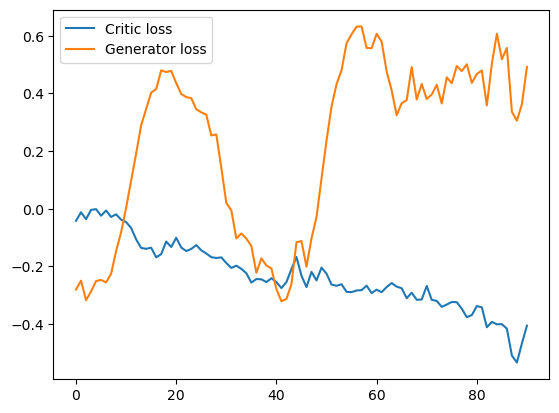

Elapsed time: 120.84710955619812 seconds


In [5]:
# set seeds
import time

random.seed(TGEditor_args.seed)
np.random.seed(TGEditor_args.seed)
torch.manual_seed(TGEditor_args.seed)
torch.cuda.manual_seed_all(TGEditor_args.seed)

start_time = time.time()

# Your code here
exp_ID = int(SystemRandom().random() * 100000)
model_name = f'{TGEditor_args.model}_{TGEditor_args.data}_{exp_ID}.pt'
save_path = os.path.join(TGEditor_args.model, model_name)
# loading the dataset

print("Original graph:")
# data.visualize()
start_time = time.time()

if TGEditor_args.model == 'DyGAN':
    print("inside dygan")
    trainer = DyGAN_trainer(
        data, max_iterations=TGEditor_args.max_iteration,
        rw_len=TGEditor_args.rw_len, batch_size=TGEditor_args.batch_size, H_gen=TGEditor_args.H_gen, H_t=TGEditor_args.H_t,
        disten=TGEditor_args.disten, H_disc=TGEditor_args.H_disc, H_inp=TGEditor_args.H_inp, z_dim=TGEditor_args.z_dim, lr=TGEditor_args.lr,
        n_critic=TGEditor_args.n_critic, gp_weight=TGEditor_args.gp_weight, betas=TGEditor_args.betas,
        l2_penalty_disc=TGEditor_args.l2_penalty_disc, l2_penalty_gen=TGEditor_args.l2_penalty_gen,
        temp_start=TGEditor_args.temp_start, baselines_stats={}, device=device)
end_time = time.time()
print(f"finished intialization, took {end_time-start_time} seconds to finish")
start_time = time.time()
trainer.train(
    create_graph_every=TGEditor_args.create_every,
    plot_graph_every=TGEditor_args.plot_every,)
# trainer.eval_model(num_eval=args.num_eval)

end_time = time.time()

print("Elapsed time:", end_time - start_time, "seconds")

# torch.save(trainer, save_path)
# !jupyter nbconvert main.ipynb --to html
# os.rename('main.html', os.path.join(config.log, f'{args.model}_{args.data}_{exp_ID}.html'))

Similarly, we store the trained TGEditor so don't bother to train one more time in the future.

In [6]:
torch.save(trainer, f'../model/DyGAN_{task}.ckpt')

In [6]:
trainer = torch.load(f'../model/DyGAN_{task}.ckpt')

Using the trained TGEditor, we edit the graph.

In [8]:
# Number of edits is loaded from the configuration file. But you can update it here if needed.
# For Chase dataset, you can choose 100 as a starting point
TGEditor_args.num_edits = 1
edited_graph = trainer.create_graph(data, i=0, visualize=False, update=False, edges_only=True, num_iterations=TGEditor_args.num_edits)
edited_graph['label'] = 0

added an edge tensor(0.9952, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
added an edge tensor(0.9933, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
added an edge tensor(0.9979, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
added an edge tensor(0.9879, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
removed an edge tensor(1.0565e-09, device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>) 0.22
added an edge tensor(0.9968, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
added an edge tensor(0.9985, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
added an edge tensor(0.9997, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
added an edge tensor(0.9953, device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward0>)
accepted for the better prob: tensor([[0.5220]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward0>)  vs  tensor([0

In [9]:
edited_graph

,src,tar,t,label
0,60,1461,0.22,0
1,182,39,0.25,0
2,388,2124,0.46,0
3,561,287,0.47,0
4,344,388,0.49,0
...,...,...,...,...
17291,346,1636,0.57,0
17292,3067,346,0.57,0
17293,346,3067,0.57,0
17294,1700,554,0.57,0


You can also store this edited graph for convenience.

In [8]:
edited_graph.to_csv('../small_AML/edit.csv', index=False)

In [6]:
edited_graph = pd.read_csv('../small_AML/edit.csv')

# Process the edited graph to updated node embedding
## HTNE node embedding training

In [14]:
start_time = time.time()

data_edited = HTNE_dataset(edge_list=edited_graph, neg_size=4, hist_len=4)
dataloader_lp_edited = load_data(data_edited, batch_size=HTNE_args.batch_size)


model_htne_post = Htne(emb_size=HTNE_args.emb_size, node_dim=data.num_nodes).to(device)
optimizer2 = SparseAdam(model_htne_post.parameters(), lr=HTNE_args.lr, eps=1e-8)

end_time = time.time()
print(f"Total processing time is: {end_time-start_time}")
# torch.cuda.empty_cache()


patience = HTNE_args.patience
max_loss = -float('inf')
for i in range(HTNE_args.epochs):
    total_loss = 0
    total_samples = 0 
    model_htne_post.train()
    print(f"Now at {i + 1} out of {HTNE_args.epochs}.")
    for j, batch in enumerate(dataloader_lp_edited):
        optimizer2.zero_grad()
        src = batch['source'].to(device)
        tar = batch['target'].to(device)
        dat = batch['date'].to(device)
        hist_nodes = batch['hist_nodes'].to(device)
        hist_times = batch['hist_times'].to(device)
        hist_masks = batch['hist_masks'].to(device)
        negs = batch['negs'].to(device)
        loss = model_htne_post(src, tar, dat, hist_nodes,
            hist_times, hist_masks, negs)
        loss = loss.sum()
        total_loss += loss.item()
        total_samples += src.size(0)
        avg_loss = total_loss / total_samples
        if (j + 1) % 5 == 0:
            print(f"{i + 1} epochs {j + 1} batch: {avg_loss:.04f}")
        loss.backward()
        optimizer2.step()
        if avg_loss < max_loss:
            max_loss = avg_loss
            # torch.save(model2.state_dict(), f'./models/htne_{args2.data}_{exp_ID}.pt')
            patience = HTNE_args.patience
        if patience == 0:
            print("early stopping")
            break
        
model_htne_post.eval()

loading edge list to CTNDE
Building index now
Finidng neighbors now
built successfully
Now building HTNE related data: Find hist
Elapsed time: 0.4848330020904541 seconds for finidng node history
64
Now building HTNE related data: Iterate data
Elapsed time: 0.48702073097229004 seconds is used for computing degree
Now building HTNE related data: Build hist
Now building HTNE related data: Node hist
done initializing
Total processing time is: 34.56719183921814
Now at 1 out of 25.
1 epochs 5 batch: 3.4128
1 epochs 10 batch: 3.3533
1 epochs 15 batch: 3.2782
1 epochs 20 batch: 3.2115
1 epochs 25 batch: 3.1461
Now at 2 out of 25.
2 epochs 5 batch: 2.7299
2 epochs 10 batch: 2.7061
2 epochs 15 batch: 2.6849
2 epochs 20 batch: 2.6547
2 epochs 25 batch: 2.6218
Now at 3 out of 25.
3 epochs 5 batch: 2.2536
3 epochs 10 batch: 2.2303
3 epochs 15 batch: 2.1971
3 epochs 20 batch: 2.1817
3 epochs 25 batch: 2.1467
Now at 4 out of 25.
4 epochs 5 batch: 1.8071
4 epochs 10 batch: 1.7940
4 epochs 15 batch: 1.

Htne(
  (node_emb): Embedding(3390, 128, sparse=True)
  (delta): Embedding(3390, 1, sparse=True)
)

This is the **post-editing embedding**, which suppose to have better performance in the fraud detection task. We store the embedding for conveneience.

In [8]:
torch.save(model_htne_post.state_dict(), f'../model/HTNE_Post_{task}.ckpt')

In the future, just simply reload it.

In [5]:
model_htne_post = Htne(emb_size=HTNE_args.emb_size, node_dim=data.num_nodes).to(device)
model_htne_post.load_state_dict(torch.load(f'../model/HTNE_Post_{task}.ckpt'))
model_htne_post.eval()

Htne(
  (node_emb): Embedding(1719984, 128, sparse=True)
  (delta): Embedding(1719984, 1, sparse=True)
)

# Fraud Detection using Logistic Regression (LR)
## Train/test data split and prepare data loading

In [15]:
# Knob that you can tune:

# This parameters are good for Chase dataset
train_size = 0.4
batch_size = 128
lr = 5e-3

In [16]:
import pandas as pd
# df = original_df.copy()
df = data.df_data.copy()
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.utils.class_weight import compute_class_weight
import time

class EdgeDataset(Dataset):
    def __init__(self, edges):
        self.edges = edges

    def __len__(self):
        return len(self.edges)

    def __getitem__(self, idx):
        return {'src': self.edges.iloc[idx]['src'], 
                'tar': self.edges.iloc[idx]['tar'], 
                'label': self.edges.iloc[idx]['label']}

def balanced_sampler(labels):
    class_counts = labels.value_counts().tolist()
    num_samples = sum(class_counts)
    class_weights = [num_samples/class_count for class_count in class_counts]
    weights = [class_weights[label] for label in labels]
    sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples)
    return sampler

start = time.time()

train_df, temp_df = train_test_split(data.df_data, train_size=train_size, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.75, stratify=temp_df['label'])

# Create Dataset and DataLoader for each set
train_dataset = EdgeDataset(train_df)
val_dataset = EdgeDataset(val_df)
test_dataset = EdgeDataset(test_df)

In [17]:
# batch_size = HTNE_args.batch_size
train_sampler = balanced_sampler(train_df['label'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True, num_workers=12, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=12, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, num_workers=12, persistent_workers=True)

## Use the Node Embedding and Build Logistic Regression Model 

In [19]:
import torch.nn.init as init
class LogisticRegression(nn.Module):
    def __init__(self, node_embeddings):
        super(LogisticRegression, self).__init__()
        self.nodes = nn.Embedding.from_pretrained(node_embeddings.weight.data.clone().detach(), freeze=True)
        self.linear = nn.Linear(256, 2)
        self.reset()
        
    def reset(self):
        init.xavier_uniform_(self.linear.weight)
        # Initialize biases to zeros
        init.zeros_(self.linear.bias)

    def forward(self, src, tar):
        src = self.nodes(src.long())
        tar = self.nodes(tar.long())
        x = torch.hstack((src, tar))
        outputs = torch.sigmoid(self.linear(x))
        return outputs

# You can change the node embedding you want to evaluate here
# model = LogisticRegression(model_htne_pre.node_emb).to(device)
model = LogisticRegression(model_htne_post.node_emb).to(device)

## Train & Evaluate with Logisitic Regression
### You can also build your evaluation loop for production

In [20]:
# Here we set the experiment numbers
num_exp = 100
train_losses = []
val_recalls = []
start = time.time()

test_recalls = []
for exp in range(num_exp):
    model.reset()
    model.train()
    class_weights = compute_class_weight(class_weight='balanced',
                                          classes=np.unique(train_df['label']),
                                          y=train_df['label'])
    
    best_recall_val = 0  # Initialize best validation recall to zero
    best_model_wts = None  # Initialize best model weights
    # print(class_weights)
    # raise
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    # criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    for cur_epoch in range(50):
        last = time.time()
        for step, i in enumerate(train_loader):
            src, tar, lab = i['src'].to(device), i['tar'].to(device), i['label'].to(device)

            optimizer.zero_grad()
            outputs = model(src, tar)
            loss = criterion(outputs, lab.long())
            loss.backward()
            optimizer.step()
            if step > 1000:
                break
        print('Epoch time:', time.time() - last)

        # Validation at every 5 epochs
        if cur_epoch % 5 == 0:
            total_val_pred = []
            total_val_true = []
            model.eval()  # Set model to evaluation mode

            with torch.no_grad():
                for step, i in enumerate(val_loader):
                    src, tar, lab = i['src'].to(device), i['tar'].to(device), i['label'].to(device)
                    outputs = model(src, tar)
                    predicted_val = torch.argmax(outputs, dim=-1).cpu().detach().tolist()
                    total_val_pred += predicted_val
                    total_val_true += lab.cpu().detach().tolist()

                    if step > 1000:
                        break

            # Calculate recall for label 1
            recall_val = recall_score(total_val_true, total_val_pred, labels=[1], average='binary')
            print(f'Epoch {exp + 1} | Validation Recall: {recall_val:.2f}')
            recall_val *= 100  # Convert to percentage
            val_recalls.append(recall_val)

            # Save the best model
            if recall_val > best_recall_val:
                best_recall_val = recall_val
                best_model_wts = model.state_dict().copy()

    
    
    # Testing
    model.load_state_dict(best_model_wts)

    # Testing with the best model
    total_test_pred = []
    total_test_true = []
    with torch.no_grad():
        for step, i in enumerate(test_loader):
            src, tar, lab = i['src'].to(device), i['tar'].to(device), i['label'].to(device)
            outputs = model(src, tar)
            predicted_test = torch.argmax(outputs, dim=-1).cpu().detach().tolist()
            total_test_pred += predicted_test
            total_test_true += lab.cpu().detach().tolist()
            if step > 1000:
                break
    
    recall_test = recall_score(total_test_true, total_test_pred, labels=[1], average='binary')
    recall_test *= 100  # Convert to percentage
    print(recall_test)
    test_recalls.append(recall_test)

end = time.time()
print(f'Total time: {end - start} seconds')
np.mean(test_recalls)

Epoch time: 0.5577688217163086
Epoch 1 | Validation Recall: 0.48
Epoch time: 0.24172091484069824
Epoch time: 0.2502164840698242
Epoch time: 0.23712754249572754
Epoch time: 0.22148466110229492
Epoch time: 0.2382364273071289
Epoch 1 | Validation Recall: 0.48
Epoch time: 0.21172761917114258
Epoch time: 0.24948501586914062
Epoch time: 0.23018312454223633
Epoch time: 0.24494671821594238
Epoch time: 0.22479033470153809
Epoch 1 | Validation Recall: 0.50
Epoch time: 0.22896075248718262
Epoch time: 0.22758841514587402
Epoch time: 0.2095959186553955
Epoch time: 0.20504975318908691
Epoch time: 0.22683954238891602
Epoch 1 | Validation Recall: 0.50
Epoch time: 0.21335721015930176
Epoch time: 0.2201688289642334
Epoch time: 0.22388362884521484
Epoch time: 0.21747255325317383
Epoch time: 0.2438819408416748
Epoch 1 | Validation Recall: 0.50
Epoch time: 0.22389006614685059
Epoch time: 0.2457585334777832
Epoch time: 0.24146771430969238
Epoch time: 0.23095083236694336
Epoch time: 0.23989200592041016
Epoch

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/nobackup/users/junhong/anaconda3/envs/pytorch1.12/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/nobackup/users/junhong/anaconda3/envs/pytorch1.12/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/nobackup/users/junhong/anaconda3/envs/pytorch1.12/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/nobackup/users/junhong/anaconda3/envs/pytorch1.12/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/nobackup/users/junhong/anaconda3/envs/pytorch1.12/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 297, in rebuild_storage_fd
    fd = df.detach()
  File "/nobackup/users/junhong/anaconda3/envs/pytorch1.12/lib/python3.9/multiprocessing/resource_sharer.p

KeyboardInterrupt: 

With the multiple experiments result, we can plot a boxplot of the recalls.

{'whiskers': [<matplotlib.lines.Line2D at 0x2010aabb7af0>,
 'caps': [<matplotlib.lines.Line2D at 0x20103b0412e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2010aabb7f10>],
 'medians': [<matplotlib.lines.Line2D at 0x20103b0416d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20103b041970>],
 'means': []}

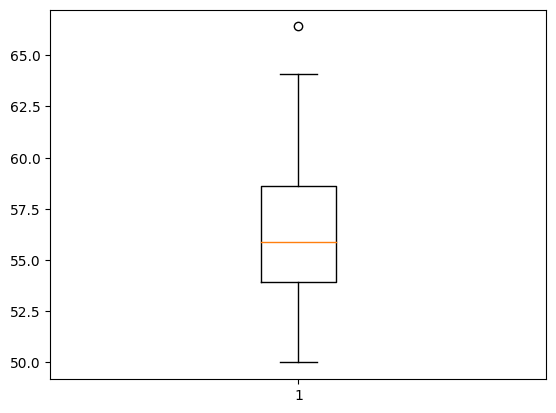

In [30]:
import matplotlib.pyplot as plt
plt.boxplot(test_recalls)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff56c458910>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff56c458d90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff56c458820>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff56c45d4c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff56c45d820>],
 'means': []}

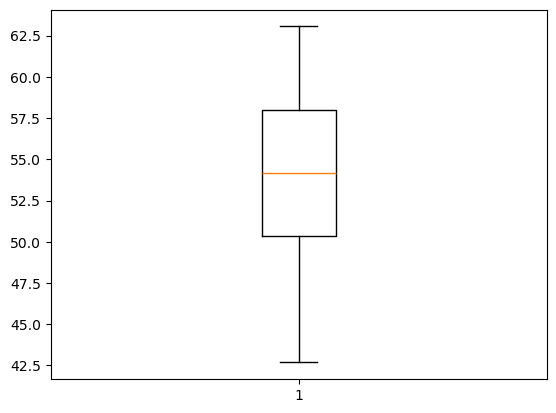

In [21]:
import matplotlib.pyplot as plt
plt.boxplot(test_recalls)

In [48]:
# Store the recall results for future analysis
filename = f'../results/{task}_pre_train{round(train_size, 1)}.txt'
with open(filename, 'w') as file:
    for recall in test_recalls:
        file.write(str(recall) + '\n')

In [ ]:
filename = f'../results/results.txt'
loaded_results = []
with open(filename, 'r') as file:
    for line in file:
        if line.strip()[0:2].isnumeric():
            loaded_results.append(float(line.strip()))
test_recalls = loaded_results